In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from collections import defaultdict
import torch
from torch import nn
from torch.nn import functional as F
import torch.utils.data as td
import torchvision as tv
import pandas as pd

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' 
print(device)

cuda


# 1. Load data

In [3]:
# alldata = np.load('processed_endomondoHR_proper_interpolate.npy', allow_pickle=True)

In [4]:
alldata = []
for i in range(10 + 1):
    alldata.extend(np.load('subDataset/processedData{}.npy'.format(i), allow_pickle=True))

In [5]:
len(alldata)

102992

# 2. data analysis

In [6]:
countType = defaultdict(int)

In [7]:
for sample in alldata:
    countType[sample['sport']] += 1

In [8]:
countType = sorted(countType.items(), key = lambda x: -x[1])

In [9]:
name = []
counts = []
for k,v in countType:
    name.append(k)
    counts.append(v)

In [10]:
countType

[('bike', 48493),
 ('run', 39201),
 ('mountain bike', 7711),
 ('bike (transport)', 3234),
 ('indoor cycling', 1320),
 ('cross-country skiing', 630),
 ('walk', 618),
 ('orienteering', 553),
 ('core stability training', 258),
 ('hiking', 193),
 ('fitness walking', 186),
 ('roller skiing', 158),
 ('skate', 124),
 ('kayaking', 60),
 ('circuit training', 53),
 ('rowing', 46),
 ('weight training', 31),
 ('downhill skiing', 24),
 ('soccer', 21),
 ('snowshoeing', 15),
 ('golf', 11),
 ('horseback riding', 7),
 ('tennis', 5),
 ('treadmill running', 5),
 ('badminton', 5),
 ('climbing', 5),
 ('basketball', 4),
 ('swimming', 4),
 ('table tennis', 3),
 ('rugby', 3),
 ('snowboarding', 2),
 ('elliptical', 2),
 ('gymnastics', 1),
 ('aerobics', 1),
 ('sailing', 1),
 ('kite surfing', 1),
 ('squash', 1),
 ('stair climing', 1),
 ('martial arts', 1)]

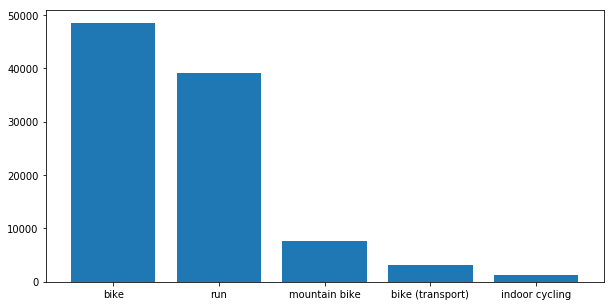

In [11]:
numOfSport = 5
plt.figure(figsize = (10,5))
plt.bar(name[:numOfSport], counts[:numOfSport])
# plt.title("The MSE  vs different lambda", fontsize=18)
# plt.xlabel("lambda", fontsize=18)
# plt.ylabel("MSE", fontsize=18)
# plt.legend()
# plt.tick_params(labelsize=15)
plt.show()
# bestIndex = np.argmin(MSEs_total)
# print('we can see the smallest MSE is {:.4f} with lambda {:.5f}.'\
#       .format(MSEs_total[bestIndex], lambs_total[bestIndex]))

In [12]:
# np.save('processedData.npy', data, allow_pickle=True)

In [13]:
# for sportType in name:
#     print(sportType)
#     with open('subDataset/'+sportType+'DataSet.json','w') as outfile:
#         for sample in data:
#             if sample['sport'] == sportType:   
# #                 print(type(sample))
#                 json.dump(sample,outfile,ensure_ascii=False)
#                 outfile.write('\n')


# 3. class and feature selection

In [14]:
UsedClass = name[:5]
# weight = sum(counts[:5])/ torch.tensor(counts[:5]).float()

In [15]:
UsedClass

['bike', 'run', 'mountain bike', 'bike (transport)', 'indoor cycling']

In [16]:
labelIndex = dict()
for i, sport in enumerate(UsedClass):
    labelIndex[sport] = i
def feature(sample, numOfFre = 5):
    featureList = []
    featureList.append(labelIndex[sample['sport']])
    featureList.extend([1,0] if sample['gender'] == 'male' else [0,1])
    
    inputFeat = []
    inputFeat.append(sample['heart_rate'][::numOfFre])
    inputFeat.append(sample['longitude'][::numOfFre])
    inputFeat.append(sample['latitude'][::numOfFre])
    inputFeat.append(sample['altitude'][::numOfFre])
    inputFeat.append(sample['distance'][::numOfFre])
    inputFeat.append(sample['time_elapsed'][::numOfFre])    
    featureList.append(list(zip(*inputFeat)))
    return featureList

In [17]:
data = [feature(sample) for sample in alldata if sample['sport'] in UsedClass]

In [18]:
train_data, val_test_data = train_test_split(data, test_size=1/5)
val_data, test_data = train_test_split(val_test_data, test_size=1/2)

In [138]:
XTrainGender = np.array([sample[1:3] for sample in train_data], dtype= 'float32')
XTrainSeq = np.array([sample[3] for sample in train_data], dtype= 'float32')
XTrain = [XTrainGender, XTrainSeq]
YTrain = np.array([sample[0] for sample in train_data])


XTestGender = torch.from_numpy(np.array([sample[1:3] for sample in test_data], dtype= 'float32')).cuda()
XTestSeq = torch.from_numpy(np.array([sample[3] for sample in test_data], dtype= 'float32')).cuda()
XTest = [XTestGender, XTestSeq]
YTest = torch.from_numpy(np.array([sample[0] for sample in test_data]))

# XTest = torch.from_numpy(test_data[:,1:]).cuda()
# YTest = torch.from_numpy(test_data[:,0])


XValGender = np.array([sample[1:3] for sample in val_data], dtype= 'float32')
XValSeq = np.array([sample[3] for sample in val_data], dtype= 'float32')
XVal = [XValGender, XValSeq]
YVal = np.array([sample[0] for sample in val_data])



In [82]:
class sportDataset(td.Dataset):
    def __init__(self, X, Y): # initialize
        super(sportDataset, self).__init__() # initialize the superclass
        self.X = X
        self.Y = Y.astype('int64')
    def __len__(self):
        return len(self.Y) # return the size of dataset
    def __getitem__(self, idx):
        x = [self.X[0][idx], self.X[1][idx]] # do transformation
        d = self.Y[idx] # get label
        return x, d # return data and label
    def number_of_classes(self):
        return self.Y.max() + 1 # return the number of classes

In [83]:
train_set = sportDataset(XTrain, YTrain)
train_loader = td.DataLoader(train_set, batch_size = 100, shuffle = True, pin_memory = True)
len(train_loader)

800

In [84]:
val_set = sportDataset(XVal, YVal)
val_loader = td.DataLoader(val_set, batch_size = 100, shuffle = False, pin_memory = True)
len(val_loader)

100

In [23]:
# test_set = sportDataset(XTest, YTest)
# test_loader = td.DataLoader(test_set, batch_size = 100, shuffle = False, pin_memory = True)
# len(test_loader)

In [79]:
for inputs, labels in train_loader:
    a = inputs
    break
    net.hidden = [item[:batch_size_t]for item in net.init_hidden()]

In [67]:
len(a)

100

# 4. train model

In [110]:
class LSTMClassifier(nn.Module):

    def __init__(self, series_dim, hidden_dim, other_dim, output_size, batch_size, num_layers = 1, \
                     seq_len = 60, device = 'cuda'):
        super(LSTMClassifier, self).__init__()
        self.device = device
        self.hidden_dim = hidden_dim
        self.output_size = output_size
        self.num_layers = num_layers
        self.batch_size = batch_size
        
        self.lstm = nn.LSTM(series_dim, hidden_dim, num_layers)
        self.hidden2label = nn.Linear(hidden_dim + other_dim, output_size)
#         self.hidden = self.init_hidden()

#     def init_hidden(self):
#         return (torch.zeros(self.num_layers, self.batch_size, self.hidden_dim).cuda(),
#                 torch.zeros(self.num_layers, self.batch_size, self.hidden_dim).cuda())

    def forward(self, X):
        x = X[1].permute(1,0,2)
        lstm_out, self.hidden = self.lstm(x)
#         print(lstm_out.shape) 
#         print(lstm_out[-1,:,:].shape) 
#         print(lstm_out.view(lstm_out.shape[1],-1).shape)
        classifierInput = torch.cat((lstm_out[-1,:,:], X[0]),1)
#         print(classifierInput.shape) 
        y  = self.hidden2label(classifierInput)
        return y

In [111]:
# LSTMmodel = LSTMClassifier(series_dim = XTrain[1].shape[2], hidden_dim = 50, other_dim = XTrain[0].shape[1], \
#                                output_size = len(UsedClass), batch_size = 100, seq_len = XTrain[1].shape[1])\
#                                 .to(device)

In [112]:
# LSTMmodel([a[0].to(LSTMmodel.device), a[1].to(LSTMmodel.device)]).shape

In [117]:
def backprop_deep(net, T, gamma=.001, rho=.9, weight = None, output_dir = None): 
    if weight is not None:
        weight = weight.cuda()
    criterion = nn.CrossEntropyLoss(weight)
    optimizer = torch.optim.SGD(net.parameters(), lr=gamma, momentum=rho)
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    minVal_loss = float('inf')
    minValCount = 0
    
    for epoch in range(T): 
        running_loss = 0.0 
        train_loss = 0.0
        train_correct = 0.0
        net.train()
        count = 0
        for inputs, labels in train_loader:
            batch_size_t = len(labels)
            inputs, labels = [inputs[0].to(net.device), inputs[1].to(net.device)], labels.to(net.device)
            # Initialize the gradients to zero
            optimizer.zero_grad()
#             net.hidden = [item[:batch_size_t] for item in net.init_hidden()]
            # Forward propagation
            outputs = net(inputs)
            # Error evaluation
            loss = criterion(outputs, labels)
            # Back propagation
            loss.backward()
            # Parameter update
            optimizer.step()
            with torch.no_grad():
                running_loss += loss.item() 
                train_loss += loss.item()
                _, y_pred = outputs.max(-1)
                correct = sum(y_pred == labels).item()
                train_correct += correct
            count += len(labels)
            if (count // len(labels)) % 1000 == 0:
                print('Iteration %d, count %d, running loss: %.3f' %
                      (epoch + 1, count, running_loss))
                running_loss = 0.0
        train_losses.append(train_loss/8)
        train_accs.append(train_correct/count*100)
        print('Iteration %d, train loss: %.3f train acc : %.3f' % \
                  (epoch + 1, train_loss/8, train_correct/count*100))               
                
        ## validation   
        val_loss = 0
        val_correct = 0.0
        val_count = 0.0
        net.eval()
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = [inputs[0].to(net.device), inputs[1].to(net.device)], labels.to(net.device)
                # Initialize the gradients to zero
                optimizer.zero_grad()
                # Forward propagation
                outputs = net(inputs)
                # Error evaluation
                loss = criterion(outputs, labels)
                val_loss += loss.item() 
                _, y_pred = outputs.max(-1)
                correct = sum(y_pred == labels).item()
                val_correct += correct
                val_count += len(labels)
                
        print('Iteration %d, validation loss: %.3f validation acc: %.3f' % \
                  (epoch + 1, val_loss, val_correct/val_count*100))
        minValCount += 1
        if val_loss < minVal_loss:
            minVal_loss = val_loss
            minValCount = 0
            
            if output_dir is None:
                output_dir = 'checkpoint/LSTM/experiment_lstm{}'.format(time.time())
            os.makedirs(output_dir, exist_ok=True)
            checkpoint_path = os.path.join(output_dir, "checkpoint.pth.tar")
            config_path = os.path.join(output_dir, "config.txt")
            state_dict = {'Net': net.state_dict(), 'Optimizer': optimizer.state_dict()}
            torch.save(state_dict, checkpoint_path)
            with open(config_path, 'w') as f:
                print(net, file=f)
            
            
        val_losses.append(val_loss)
        val_accs.append(val_correct/val_count*100)
        if minValCount > 20:
            break
    checkpoint = torch.load(checkpoint_path, map_location=net.device)
    net.load_state_dict(checkpoint['Net'])
    print("Finish training for {} epochs".format(T))
    return train_losses, val_losses, train_accs, val_accs

In [141]:
LSTMmodel = LSTMClassifier(series_dim = XTrain[1].shape[2], hidden_dim = 50, other_dim = XTrain[0].shape[1], \
                               output_size = len(UsedClass), batch_size = 100, seq_len = XTrain[1].shape[1], \
                                num_layers = 2).to(device)

In [142]:
epochs = 500
train_losses, val_losses, train_accs, val_accs = backprop_deep(LSTMmodel, T=epochs, weight = None)

Iteration 1, train loss: 105.600 train acc : 64.592
Iteration 1, validation loss: 84.803 validation acc: 72.319
Iteration 2, train loss: 72.339 train acc : 77.558
Iteration 2, validation loss: 66.134 validation acc: 79.052
Iteration 3, train loss: 66.254 train acc : 79.279
Iteration 3, validation loss: 63.128 validation acc: 80.482
Iteration 4, train loss: 64.263 train acc : 79.782
Iteration 4, validation loss: 62.057 validation acc: 80.732
Iteration 5, train loss: 63.005 train acc : 80.109
Iteration 5, validation loss: 60.586 validation acc: 80.472
Iteration 6, train loss: 61.943 train acc : 80.329
Iteration 6, validation loss: 61.138 validation acc: 80.512
Iteration 7, train loss: 60.718 train acc : 80.728
Iteration 7, validation loss: 59.193 validation acc: 81.222
Iteration 8, train loss: 60.549 train acc : 80.521
Iteration 8, validation loss: 59.418 validation acc: 80.692
Iteration 9, train loss: 59.811 train acc : 80.691
Iteration 9, validation loss: 62.032 validation acc: 80.432


Iteration 74, train loss: 40.273 train acc : 85.930
Iteration 74, validation loss: 39.420 validation acc: 86.385
Iteration 75, train loss: 40.083 train acc : 86.010
Iteration 75, validation loss: 39.768 validation acc: 86.335
Iteration 76, train loss: 40.065 train acc : 86.052
Iteration 76, validation loss: 39.526 validation acc: 86.064
Iteration 77, train loss: 39.799 train acc : 86.063
Iteration 77, validation loss: 39.009 validation acc: 86.445
Iteration 78, train loss: 39.942 train acc : 86.053
Iteration 78, validation loss: 40.097 validation acc: 85.814
Iteration 79, train loss: 40.054 train acc : 85.992
Iteration 79, validation loss: 39.754 validation acc: 85.914
Iteration 80, train loss: 39.965 train acc : 85.975
Iteration 80, validation loss: 39.742 validation acc: 86.124
Iteration 81, train loss: 39.515 train acc : 86.181
Iteration 81, validation loss: 41.332 validation acc: 85.394
Iteration 82, train loss: 39.656 train acc : 86.082
Iteration 82, validation loss: 38.674 valida

Iteration 146, train loss: 35.044 train acc : 87.692
Iteration 146, validation loss: 36.408 validation acc: 87.085
Iteration 147, train loss: 34.997 train acc : 87.584
Iteration 147, validation loss: 35.836 validation acc: 87.075
Iteration 148, train loss: 34.966 train acc : 87.671
Iteration 148, validation loss: 35.901 validation acc: 87.095
Iteration 149, train loss: 34.983 train acc : 87.559
Iteration 149, validation loss: 36.926 validation acc: 86.845
Iteration 150, train loss: 35.133 train acc : 87.595
Iteration 150, validation loss: 36.628 validation acc: 86.785
Iteration 151, train loss: 34.950 train acc : 87.595
Iteration 151, validation loss: 36.495 validation acc: 87.125
Iteration 152, train loss: 35.106 train acc : 87.610
Iteration 152, validation loss: 36.762 validation acc: 87.155
Iteration 153, train loss: 34.872 train acc : 87.671
Iteration 153, validation loss: 36.887 validation acc: 87.115
Iteration 154, train loss: 34.812 train acc : 87.621
Iteration 154, validation l

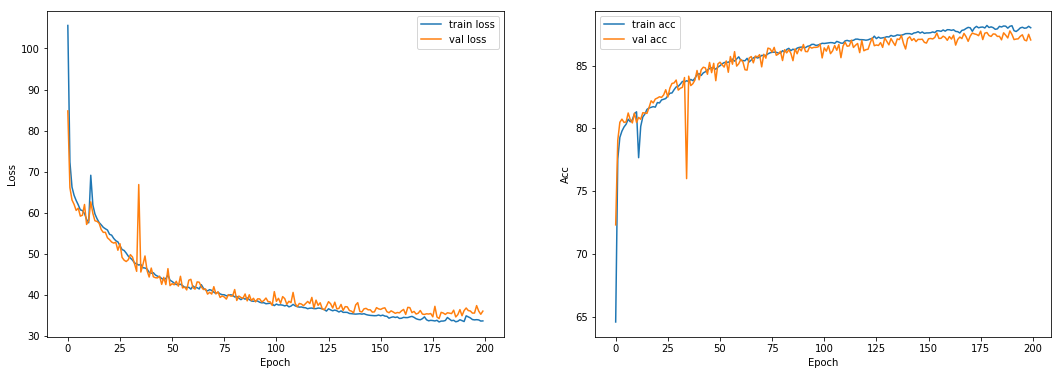

In [143]:
final_epochs = len(train_losses)
fig, axes = plt.subplots(ncols=2, figsize=(18, 6))

axes[0].plot(range(final_epochs), train_losses, label = 'train loss')
axes[0].plot(range(final_epochs), val_losses, label = 'val loss')
axes[0].set_xlabel('Epoch') 
axes[0].set_ylabel('Loss')
axes[0].legend()

axes[1].plot(range(final_epochs), train_accs, label = 'train acc')
axes[1].plot(range(final_epochs), val_accs, label = 'val acc')
axes[1].set_xlabel('Epoch') 
axes[1].set_ylabel('Acc')
axes[1].legend()

# 5. test model

In [144]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
def testModel(xtest, ytest, net): 
    net.eval()
    with torch.no_grad():
        outputs = net(xtest).cpu()
    y_val = np.argmax(outputs, axis=1)   
    print(confusion_matrix(ytest,y_val))
    print(classification_report(ytest,y_val))
    print(accuracy_score(ytest, y_val))
# def testModel(xtest, ytest, net): 
#     net.eval()
#     with torch.no_grad():
#         outputs = net(xtest)
#     _, y_val = outputs.max(-1)
#     correct = sum(y_val == ytest).item()
#     acc =  correct / len(y_val) * 100
#     return acc, correct

In [145]:
testModel(XTest, YTest, LSTMmodel)

[[4454  133  170   46    8]
 [ 190 3731   29    7    2]
 [ 382   71  331   13    0]
 [ 104    9   11  161    0]
 [ 101    3    0    0   40]]
              precision    recall  f1-score   support

           0       0.85      0.93      0.89      4811
           1       0.95      0.94      0.94      3959
           2       0.61      0.42      0.49       797
           3       0.71      0.56      0.63       285
           4       0.80      0.28      0.41       144

   micro avg       0.87      0.87      0.87      9996
   macro avg       0.78      0.63      0.67      9996
weighted avg       0.86      0.87      0.86      9996

0.8720488195278111
